In [14]:
from datetime import datetime
import pandas as pd
import numpy as np

In [15]:
tp = pd.read_csv("Result_Wait-4.csv", iterator=True, chunksize=1000)
df = pd.concat(tp, ignore_index=True)

df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%d-%b-%Y %H:%M:%S'))
df['date'] = df['time'].apply(lambda x: x.strftime("%Y/%m/%d"))
# df['detail_time'] = df['time'].apply(lambda x: x.strftime("%H:%M:%S"))
df['detail_time'] = df['time'].apply(lambda x: x.time())
df['weekday'] = df['time'].apply(lambda x: x.strftime('%A'))

In [16]:
df.head(5)

,posture,x,y,speed,week,ind,traitement,breed,time,temperature,date,detail_time,weekday
0,3,3.861676,92.686224,0.000000,5,200002,1,0,2020-08-19 08:30:00,29.0,2020/08/19,08:30:00,Wednesday
1,3,5.414635,87.580417,5.336754,5,200002,1,0,2020-08-19 08:30:30,29.0,2020/08/19,08:30:30,Wednesday
2,3,7.015623,99.617082,12.142671,5,200002,1,0,2020-08-19 08:31:00,29.0,2020/08/19,08:31:00,Wednesday
3,4,93.993134,155.479983,103.371907,5,200002,1,0,2020-08-19 08:31:30,29.0,2020/08/19,08:31:30,Wednesday
4,4,131.654742,82.356483,82.252313,5,200002,1,0,2020-08-19 08:32:00,29.5,2020/08/19,08:32:00,Wednesday


In [17]:
def drop_nan(df):
    print('nan:', df[df['ind'].isna()])
    df = df.dropna()
    df['ind'] = df['ind'].astype(int).astype(str)
    print(df.shape)
    return df

df = drop_nan(df)
# agg_df = drop_nan(agg_df)
# adj_df = drop_nan(adj_df)

nan: Empty DataFrame
Columns: [posture, x, y, speed, week, ind, traitement, breed, time, temperature, date, detail_time, weekday]
Index: []
(537350, 13)


In [18]:
timestamp = df['time'].unique()
pid_list = df['ind'].unique()

predict = ['posture']
feature = ['x', 'y', 'speed', 'traitement', 'breed', 'temperature']
feature_df = ['ind', 'posture', 'x', 'y', 'speed', 'traitement', 'breed', 'temperature', 'time']
agg_time = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq="30min")

# data
data = None #np.empty((len(timestamp), len(pid_list), len(feature)))
adj = np.zeros((len(agg_time), len(pid_list), len(pid_list)))
agg_df = None

for p_idx, _pid in enumerate(pid_list):
       filter_B = df['ind'] == _pid
       select_pig = df[ filter_B ].set_index('time').resample("30min").ffill()
       select_pig['time'] = select_pig.index
       select_pig.index = range(len(select_pig))
       row = select_pig[feature].to_numpy() #.ravel()

       # label
       y_row = pd.get_dummies(select_pig['posture'])
       # y_row[np.isnan(y_row)] = 1
       
       row = np.expand_dims(row, axis=1)
       # print(row.shape)
       y_row = np.expand_dims(y_row, axis=1)

       if row.shape[0] == 0:
              data[:][p_idx] =  np.empty(len(feature))
              y_truth[t_idx][p_idx] = np.nan
              print('row nan')
       else:
              if data is None:
                     data = row
                     y_truth = y_row
                     agg_df = select_pig[feature_df]
              else:
                     data = np.concatenate((data, row), axis=1)
                     y_truth = np.concatenate((y_truth, y_row), axis=1)
                     agg_df = pd.concat([agg_df, select_pig[feature_df]])
       for p_idx_2, _pid_2 in enumerate(pid_list):
              filter_C = df['ind'] == _pid_2
              select_pig_2 = df[ filter_C ].set_index('time').resample("30min").ffill()

              first_x = select_pig['x'].values
              first_y = select_pig['y'].values

              sec_x = select_pig_2['x'].values
              sec_y = select_pig_2['y'].values

              dist = (first_x - sec_x) ** 2 + (first_y - sec_y) ** 2
              dist = dist ** 0.5
              adj[:, p_idx, p_idx_2] = dist

# turn the label to dummy
agg_df.index = range(len(agg_df))

# output
print(data.shape, y_truth.shape, adj.shape)

(4579, 10, 6) (4579, 10, 5) (4579, 10, 10)


In [19]:
import networkx as nx

def cal_centrality(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)

    # G is the Karate Club Graph 
    deg_centrality = nx.degree_centrality(G) 
    # print(deg_centrality) 

    # G is the Karate Social Graph 
    close_centrality = nx.closeness_centrality(G)   
    # print(close_centrality) 

    # G is the Karate Social Graph, parameters normalized 
    # and endpoints ensure whether we normalize the value 
    # and consider the endpoints respectively. 
    bet_centrality = nx.betweenness_centrality(G, normalized = True,  
                                                  endpoints = False) 
    # print(bet_centrality) 

    # G is the Karate Social Graph 
    pr = nx.pagerank(G, alpha = 0.8) 
    # print(pr) 
    return deg_centrality, close_centrality, bet_centrality, pr

test = cal_centrality(adj[0] > 70)

In [20]:
def format_df(cen_dict):
    for i in range(10):
        if i in cen_dict.keys():
            cen_dict[i] = [cen_dict[i]]
        else:
            cen_dict[i] = [0]
    result = pd.DataFrame(cen_dict)
    result = result.reindex(sorted(result.columns), axis=1)
    return result

deg_df = None
close_df  = None
bet_df = None
pr_df = None

for adj_row in adj:
    deg, close, bet, pr = cal_centrality(adj_row > 70)
    if deg_df is None:
        deg_df = format_df(deg)
        close_df = format_df(close)
        bet_df = format_df(bet)
        pr_df = format_df(pr)
    else:
        deg_df = pd.concat([deg_df, format_df(deg)], ignore_index=True)
        close_df = pd.concat([close_df, format_df(close)], ignore_index=True)
        bet_df = pd.concat([bet_df, format_df(bet)], ignore_index=True)
        pr_df = pd.concat([pr_df, format_df(pr)], ignore_index=True)

print(deg_df.head(5))

          0         1         2         3         4         5         6  \
0  0.750000  0.500000  0.500000  0.625000  0.000000  0.375000  0.750000   
1  0.777778  0.777778  0.888889  0.666667  0.555556  0.666667  0.444444   
2  1.000000  0.666667  0.777778  0.666667  0.555556  0.777778  0.666667   
3  0.555556  0.777778  0.555556  0.666667  0.777778  0.777778  0.666667   
4  1.000000  0.666667  0.444444  0.777778  0.444444  0.555556  0.444444   

          7         8         9  
0  0.500000  0.750000  0.750000  
1  0.888889  0.666667  0.777778  
2  0.555556  0.666667  0.555556  
3  0.555556  0.777778  0.777778  
4  0.777778  0.777778  0.555556  


In [21]:
num_row = 4579

adj_df = agg_df

for p_id in pid_list:
    adj_df[p_id] = 0

for i, p_id in enumerate(pid_list):
    link = adj[:, i]
    linked = link > 70
    # print(linked.shape, adj_df.loc[num_row * i: num_row *(i+1)-1, pid_list].shape)
    adj_df.loc[num_row * i : num_row * (i+1)-1, pid_list] = linked

    # centrality
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'num_nb'] = np.sum(linked, axis=1)
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'degree'] = deg_df[i]
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'close'] = close_df[i]
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'bet'] = bet_df[i]
    adj_df.loc[num_row * i : num_row * (i+1)-1, 'pr'] = pr_df[i]


print(adj_df.head(5))

      ind  posture          x           y     speed  traitement  breed  \
0  200002      4.0  11.978012   70.496874  0.000000         1.0    0.0   
1  200002      3.0  88.959491  134.882619  9.047293         1.0    0.0   
2  200002      5.0  80.451316  125.843261  3.072955         1.0    0.0   
3  200002      4.0   9.492997   69.291319  1.218399         1.0    0.0   
4  200002      5.0  42.256037  134.660285  9.000454         1.0    0.0   

   temperature                time 200002  ... 204926 204927 204938 204945  \
0         29.0 2020-06-24 08:30:00  False  ...   True  False   True  False   
1         29.0 2020-06-24 09:00:00  False  ...   True   True   True   True   
2         29.0 2020-06-24 09:30:00  False  ...   True   True   True   True   
3         29.0 2020-06-24 10:00:00  False  ...  False   True   True  False   
4         29.0 2020-06-24 10:30:00  False  ...   True   True   True   True   

  204946 num_nb    degree     close       bet        pr  
0   True    6.0  0.750000  0

In [22]:
def turn_dummy(data_df, col_name):
    # label
    label_oh = pd.get_dummies(data_df[col_name].astype(int), prefix=col_name)
    data_df = data_df.drop(col_name, axis=1)
    data_df = data_df.join(label_oh)
    # print(data_df.head(5))
    return data_df

# drop nan
agg_df = drop_nan(agg_df)
adj_df = drop_nan(adj_df)

agg_df = turn_dummy(agg_df, 'posture')
adj_df = turn_dummy(adj_df, 'posture')

nan:        ind  posture   x   y  speed  traitement  breed  temperature  \
18316  NaN      NaN NaN NaN    NaN         NaN    NaN          NaN   

                     time 200002  ... 204926 204927 204938 204945 204946  \
18316 2020-06-24 08:30:00  False  ...  False  False  False  False  False   

      num_nb degree close bet  pr  
18316    0.0    NaN   NaN NaN NaN  

[1 rows x 24 columns]
(4579, 24)
nan:        ind  posture   x   y  speed  traitement  breed  temperature  \
18316  NaN      NaN NaN NaN    NaN         NaN    NaN          NaN   

                     time 200002  ... 204926 204927 204938 204945 204946  \
18316 2020-06-24 08:30:00  False  ...  False  False  False  False  False   

      num_nb degree close bet  pr  
18316    0.0    NaN   NaN NaN NaN  

[1 rows x 24 columns]
(4579, 24)


c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\Gina\anaconda3\envs\exchange\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
adj_df = adj_df.drop('ind', axis=1)
adj_df.head(5)

,x,y,speed,traitement,breed,temperature,time,200002,200004,200011,...,num_nb,degree,close,bet,pr,posture_1,posture_2,posture_3,posture_4,posture_5
0,11.978012,70.496874,0.000000,1.0,0.0,29.0,2020-06-24 08:30:00,False,True,True,...,6.0,0.750000,0.800000,0.119048,0.133792,0,0,0,1,0
1,88.959491,134.882619,9.047293,1.0,0.0,29.0,2020-06-24 09:00:00,False,False,True,...,7.0,0.777778,0.818182,0.052778,0.108011,0,0,1,0,0
2,80.451316,125.843261,3.072955,1.0,0.0,29.0,2020-06-24 09:30:00,False,True,True,...,9.0,1.000000,1.000000,0.073148,0.137479,0,0,0,0,1
3,9.492997,69.291319,1.218399,1.0,0.0,29.0,2020-06-24 10:00:00,False,False,True,...,5.0,0.555556,0.692308,0.043519,0.085345,0,0,0,1,0
4,42.256037,134.660285,9.000454,1.0,0.0,29.0,2020-06-24 10:30:00,False,True,True,...,9.0,1.000000,1.000000,0.100794,0.146425,0,0,0,0,1


In [24]:
agg_df = agg_df.drop('ind', axis=1)
agg_df.head(5)

,x,y,speed,traitement,breed,temperature,time,200002,200004,200011,...,num_nb,degree,close,bet,pr,posture_1,posture_2,posture_3,posture_4,posture_5
0,11.978012,70.496874,0.000000,1.0,0.0,29.0,2020-06-24 08:30:00,False,True,True,...,6.0,0.750000,0.800000,0.119048,0.133792,0,0,0,1,0
1,88.959491,134.882619,9.047293,1.0,0.0,29.0,2020-06-24 09:00:00,False,False,True,...,7.0,0.777778,0.818182,0.052778,0.108011,0,0,1,0,0
2,80.451316,125.843261,3.072955,1.0,0.0,29.0,2020-06-24 09:30:00,False,True,True,...,9.0,1.000000,1.000000,0.073148,0.137479,0,0,0,0,1
3,9.492997,69.291319,1.218399,1.0,0.0,29.0,2020-06-24 10:00:00,False,False,True,...,5.0,0.555556,0.692308,0.043519,0.085345,0,0,0,1,0
4,42.256037,134.660285,9.000454,1.0,0.0,29.0,2020-06-24 10:30:00,False,True,True,...,9.0,1.000000,1.000000,0.100794,0.146425,0,0,0,0,1


## Export the data

In [25]:
print(agg_df.shape)

agg_df.to_csv("data/data_agg_30Min.csv")

(4579, 27)


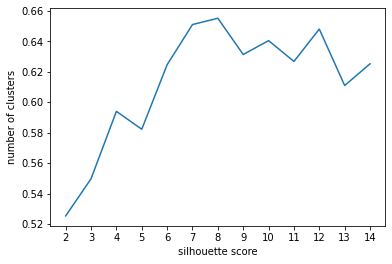

In [26]:
import matplotlib.pyplot as plt
# from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.ticker as mticker


silhouette_avg = []
X = agg_df.copy()
X = X.drop('time', axis=1)
X = X.drop('traitement', axis=1)
X = X.drop('breed', axis=1)

for i in range(2, 15):
    # X = agg_df[pid_list]
    # X['speed'] = agg_df['speed']
    kmeans_fit = KMeans(n_clusters = i).fit(X.to_numpy())
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))

plt.xlabel("silhouette score")
plt.ylabel("number of clusters")

plt.plot(range(2, 15), silhouette_avg)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

In [31]:
num_cluster = pd.DataFrame()
num_cluster['number of clusters'] = [i for i in range(2, 15)]
num_cluster['silhouette score'] = silhouette_avg
num_cluster.to_csv("data/num_of_cluster.csv")

In [29]:
adj[1:].shape

(4578, 10, 10)

In [37]:
tmp = np.where(np.isin(adj, ['NA', 'N/A']), np.nan, arr).astype(float)
new_arr = tmp[~np.isnan(tmp).any(axis=1)]
print(new_arr)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_metric = np.zeros((4578, 10))

for i in range(len(adj) - 1):
    for j in range(10):
        # print(adj[i+1][j].shape, adj[i][j].shape)
        cos_metric[i] = cosine_similarity(adj[i+1], adj[i])

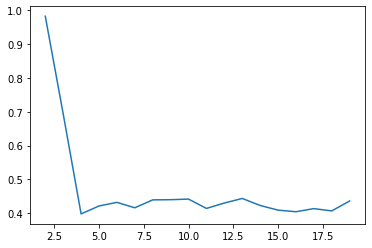

In [19]:
plt.plot(range(2, 20), silhouette_avg)

In [14]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def PCA_df(data_df):
    x = data_df.values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    # PCA
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)

    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['PCA_1', 'PCA_2'])
    return principalDf, pca
    

For n_clusters = 2 The average silhouette_score is : 0.5253006185040221
centroid:
 [[-2.2235713  -0.31864679]
 [ 2.24798469  0.32214532]]
For n_clusters = 3 The average silhouette_score is : 0.5497084287963099
centroid:
 [[-2.44363489  0.66513433]
 [ 2.37026062  0.25730587]
 [-0.66561334 -3.82855142]]
For n_clusters = 4 The average silhouette_score is : 0.5940063035732417
centroid:
 [[-0.70893141 -3.91727095]
 [-2.68952834  0.64327659]
 [ 4.66359756  1.368463  ]
 [ 1.62184362  0.06980033]]
For n_clusters = 5 The average silhouette_score is : 0.582268869986579
centroid:
 [[ 1.65222486  0.05078613]
 [-3.25105902  1.95192386]
 [-0.68019266 -4.03324945]
 [-2.18042943 -0.37546487]
 [ 4.47597518  1.42851161]]
For n_clusters = 6 The average silhouette_score is : 0.6246481175378046
centroid:
 [[-0.68128925 -4.04152475]
 [ 2.06654805 -0.64476513]
 [-3.41998672  1.87863309]
 [-2.19105879 -0.40165262]
 [ 0.91663994  1.42493888]
 [ 4.66435302  1.4320236 ]]


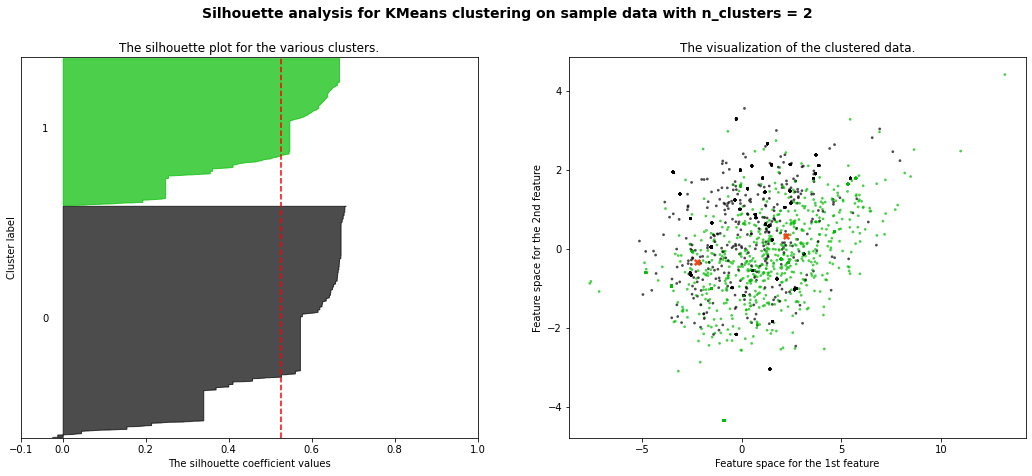

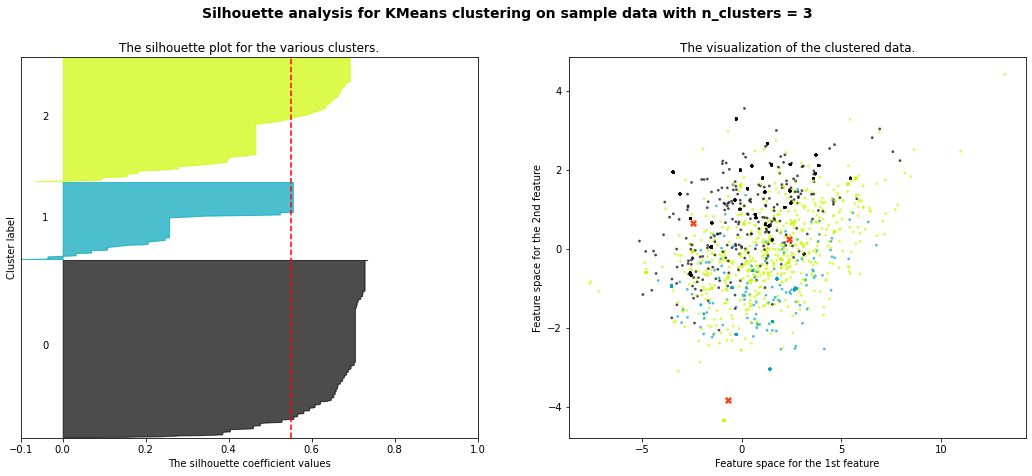

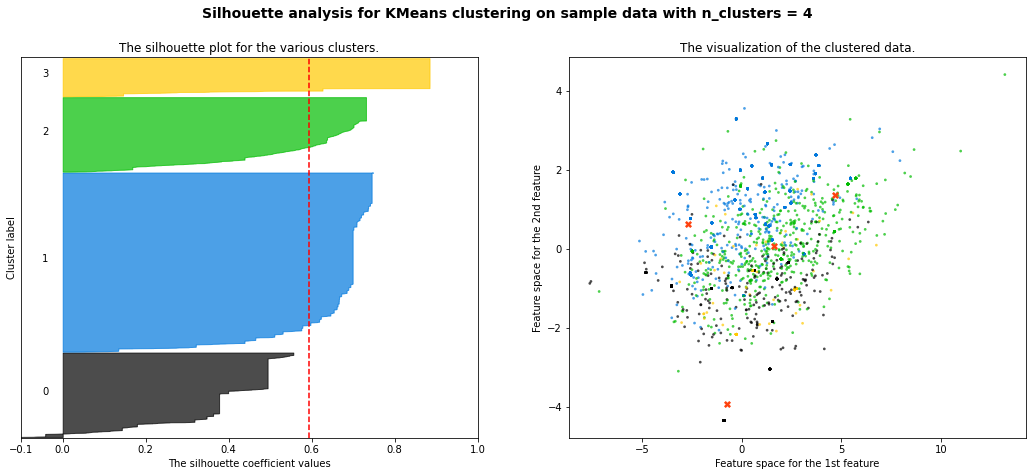

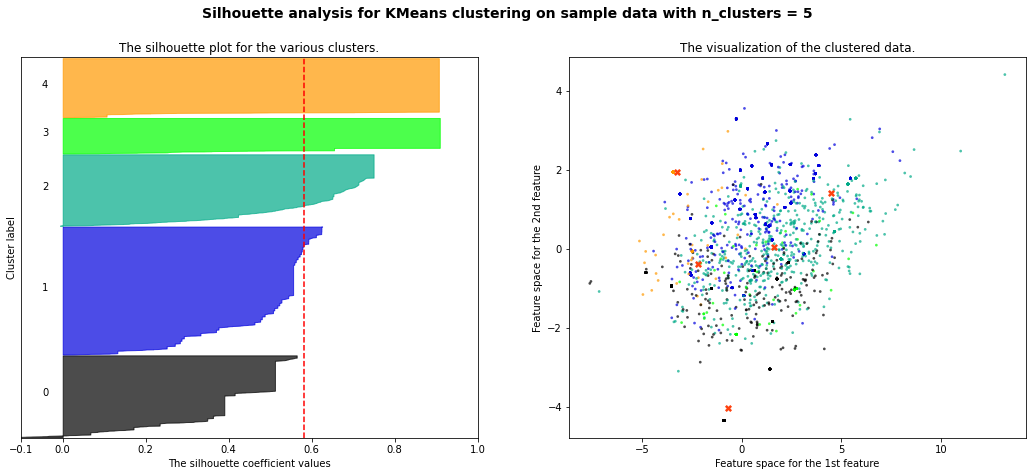

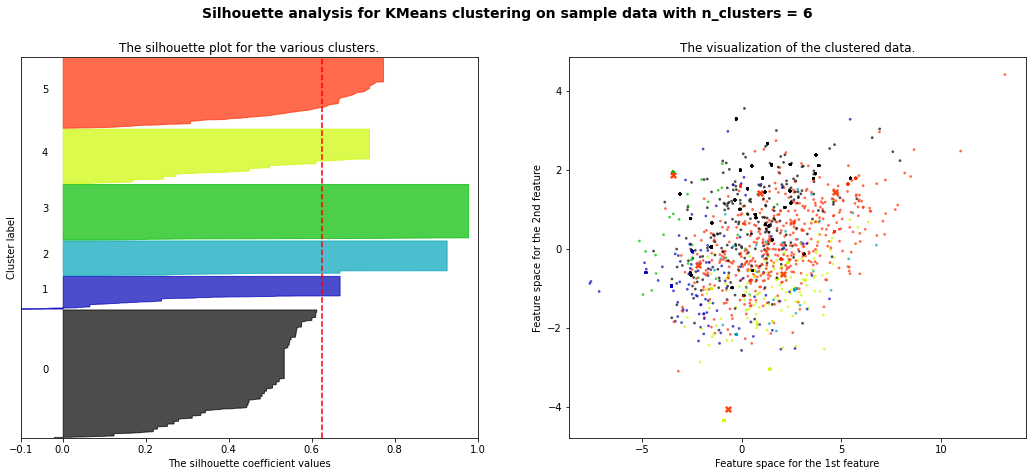

In [42]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]
X = agg_df.copy()
X = X.drop('time', axis=1)
X = X.drop('traitement', axis=1)
X = X.drop('breed', axis=1)

transform_X, pca_transform = PCA_df(X)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # print('centroid:', clusterer.cluster_centers_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    ax2.scatter(
        transform_X.loc[:, 'PCA_1'], transform_X.loc[:, 'PCA_2'], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # centroid ***
    trans_clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    _ = trans_clusterer.fit_predict(transform_X.to_numpy())
    centroid = trans_clusterer.cluster_centers_
    print('centroid:\n', centroid)
    # centroid = pca_transform.transform(clusterer.cluster_centers_)

    # color = cm.nipy_spectral(float([ i for i in range(n_clusters)]) / n_clusters)
    ax2.scatter(
        centroid[:, 0], centroid[:, 1], marker="X", s=50, lw=0, alpha=1, c='#FE420F'
    )
    # print(centroid)
    

    # Labeling the clusters
    # centers = clusterer.cluster_centers_
    # PCA_centers = pca_transform.transform(centers)
    # # Draw white circles at cluster centers
    # ax2.scatter(
    #     PCA_centers[:, 0],
    #     PCA_centers[:, 1],
    #     marker="o",
    #     c="white",
    #     alpha=1,
    #     s=200,
    #     edgecolor="k",
    # )

    # for i, c in enumerate(PCA_centers):
    #     ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [38]:
trans_clusterer.cluster_centers_

AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

In [19]:
pca_transform.transform(clusterer.cluster_centers_)

array([[  7.49339431,  -2.52020459],
       [ 14.7626033 , -26.32531179],
       [ 22.5429207 , -37.14686899],
       [ -0.14610491,  12.89309957],
       [ 22.02425686, -44.31338436],
       [ 18.96607452, -32.95703207]])